<h1>  Human Activity Recognition </h1>

This project is to build a model that predicts the human activities such as Walking, Walking_Upstairs, Walking_Downstairs, Sitting, Standing or Laying based on the data that is collected from the accelerometer(for measuring acceleration) and gyroscope(measure angular velocity)

REF: https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones

<h2> DataSet Overview </h2>

* Accelerometer and Gyroscope readings are taken from 30 volunteers(referred as subjects) while performing the following 6 Activities.

    1. Walking     
    2. WalkingUpstairs 
    3. WalkingDownstairs 
    4. Standing 
    5. Sitting 
    6. Lying.


* Readings are divided into a window of 2.56 seconds with 50% overlapping. 

* Accelerometer readings are divided into gravity acceleration and body acceleration readings,
  which has x,y and z components each.

* Gyroscope readings are the measure of angular velocities which has x,y and z components.

* Jerk signals are calculated for BodyAcceleration readings.

* Fourier Transforms are made on the above time readings to obtain frequency readings.

* Now, on all the base signal readings., mean, max, mad, sma, arcoefficient, engerybands,entropy etc., are calculated for each window.

* We get a feature vector of 561 features and these features are given in the dataset.

* Each window of readings is a datapoint of 561 features.

## Problem Framework

* 30 subjects(volunteers) data is randomly split to 70%(21) test and 30%(7) train data.
* Each datapoint corresponds one of the 6 Activities.


<h2> Objective: </h2> 
Given a new datapoint we have to predict the Activity

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings("ignore")

In [3]:
# get the features from the file features.txt
features = list()
with open('/content/drive/MyDrive/project/Human activity recognition /UCI_HAR_Dataset/features.txt') as f:
    features = [line.split()[1] for line in f.readlines()]
print('No of Features: {}'.format(len(features)))


No of Features: 561


In [4]:
"""
Looks like there are some feature names that are duplicate
and training data has 561 dimensionality
Hence, modifying the name of the features in order to get rid of future problems while loading the data into the dataframe
"""

#https://github.com/pandas-dev/pandas/issues/10496

from collections import Counter
Counter(features).most_common(50)

[('fBodyAcc-bandsEnergy()-1,8', 3),
 ('fBodyAcc-bandsEnergy()-9,16', 3),
 ('fBodyAcc-bandsEnergy()-17,24', 3),
 ('fBodyAcc-bandsEnergy()-25,32', 3),
 ('fBodyAcc-bandsEnergy()-33,40', 3),
 ('fBodyAcc-bandsEnergy()-41,48', 3),
 ('fBodyAcc-bandsEnergy()-49,56', 3),
 ('fBodyAcc-bandsEnergy()-57,64', 3),
 ('fBodyAcc-bandsEnergy()-1,16', 3),
 ('fBodyAcc-bandsEnergy()-17,32', 3),
 ('fBodyAcc-bandsEnergy()-33,48', 3),
 ('fBodyAcc-bandsEnergy()-49,64', 3),
 ('fBodyAcc-bandsEnergy()-1,24', 3),
 ('fBodyAcc-bandsEnergy()-25,48', 3),
 ('fBodyAccJerk-bandsEnergy()-1,8', 3),
 ('fBodyAccJerk-bandsEnergy()-9,16', 3),
 ('fBodyAccJerk-bandsEnergy()-17,24', 3),
 ('fBodyAccJerk-bandsEnergy()-25,32', 3),
 ('fBodyAccJerk-bandsEnergy()-33,40', 3),
 ('fBodyAccJerk-bandsEnergy()-41,48', 3),
 ('fBodyAccJerk-bandsEnergy()-49,56', 3),
 ('fBodyAccJerk-bandsEnergy()-57,64', 3),
 ('fBodyAccJerk-bandsEnergy()-1,16', 3),
 ('fBodyAccJerk-bandsEnergy()-17,32', 3),
 ('fBodyAccJerk-bandsEnergy()-33,48', 3),
 ('fBodyAccJerk

In [5]:
#code for getting unique feature names 
#avoiding the use of set as we want to preserve the order of the feature names 
i=1
unique_features = []
for val in features:
      if val not in unique_features:
        unique_features.append(val)
      else:
        new_val = val+'_'+str(i)
        unique_features.append(new_val)
        i+=1

unique_features =  list(unique_features)

<h3> Obtain TRAIN DATA 

In [6]:
# get the data from txt files to pandas dataffame
X_train = pd.read_csv('/content/drive/MyDrive/project/Human activity recognition /UCI_HAR_Dataset/train/X_train.txt', delim_whitespace=True, header=None, names=unique_features)

# add subject column to the dataframe
X_train['subject'] = pd.read_csv('/content/drive/MyDrive/project/Human activity recognition /UCI_HAR_Dataset/train/subject_train.txt', header=None, squeeze=True)

y_train = pd.read_csv('/content/drive/MyDrive/project/Human activity recognition /UCI_HAR_Dataset/train/y_train.txt', names=['Activity'], squeeze=True)
y_train_labels = y_train.map({1: 'WALKING', 2:'WALKING_UPSTAIRS',3:'WALKING_DOWNSTAIRS',\
                       4:'SITTING', 5:'STANDING',6:'LAYING'})

# put all columns in a single dataframe
train = X_train
train['Activity'] = y_train
train['ActivityName'] = y_train_labels
train.sample()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity,ActivityName
167,0.226228,-0.053719,-0.112521,-0.350926,-0.009298,0.007788,-0.398986,0.047078,0.023589,-0.061188,...,0.135778,0.659119,-0.984461,0.674556,-0.695159,0.304615,0.059935,1,2,WALKING_UPSTAIRS


In [7]:
train.shape

(7352, 564)

<h3> Obtain TEST DATA </h3>

In [11]:
# get the data from txt files to pandas dataffame
X_test = pd.read_csv('/content/drive/MyDrive/project/Human activity recognition /UCI_HAR_Dataset/test/X_test.txt', delim_whitespace=True, header=None, names=unique_features)

# add subject column to the dataframe
X_test['subject'] = pd.read_csv('/content/drive/MyDrive/project/Human activity recognition /UCI_HAR_Dataset/test/subject_test.txt', header=None, squeeze=True)

# get y labels from the txt file
y_test = pd.read_csv('/content/drive/MyDrive/project/Human activity recognition /UCI_HAR_Dataset/test/y_test.txt', names=['Activity'], squeeze=True)
y_test_labels = y_test.map({1: 'WALKING', 2:'WALKING_UPSTAIRS',3:'WALKING_DOWNSTAIRS',\
                       4:'SITTING', 5:'STANDING',6:'LAYING'})


# put all columns in a single dataframe
test = X_test
test['Activity'] = y_test
test['ActivityName'] = y_test_labels
test.sample()


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity,ActivityName
459,0.348632,-0.041476,-0.055006,-0.11496,-0.111459,-0.424277,-0.231481,-0.120486,-0.417794,0.208494,...,-0.467467,0.685512,-0.76733,-0.444717,-0.775493,0.25161,-0.005657,4,2,WALKING_UPSTAIRS


In [9]:
test.shape

(2947, 564)

<h3> Check for duplicates </h3>

In [12]:
print('No of duplicates in train: {}'.format(sum(train.duplicated())))
print('No of duplicates in test : {}'.format(sum(test.duplicated())))

No of duplicates in train: 0
No of duplicates in test : 0


<h3> Checking for NAN/NULL values </h3>

In [13]:
print('We have {} NaN/Null values in train'.format(train.isnull().values.sum()))
print('We have {} NaN/Null values in test'.format(test.isnull().values.sum()))

We have 0 NaN/Null values in train
We have 0 NaN/Null values in test


<h3>  Checking for Data Imbalance

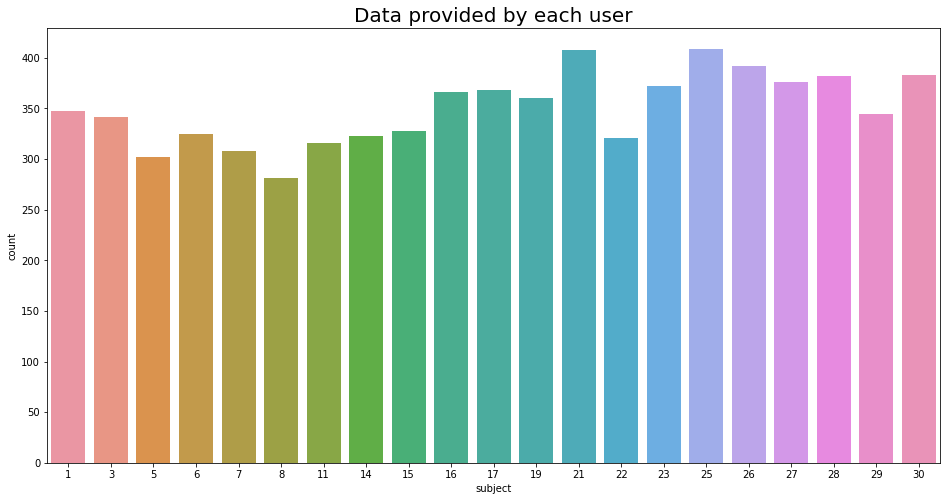

In [14]:
plt.figure(figsize=(16,8))
plt.title('Data provided by each user', fontsize=20)
sns.countplot(x='subject', data = train)
plt.show()

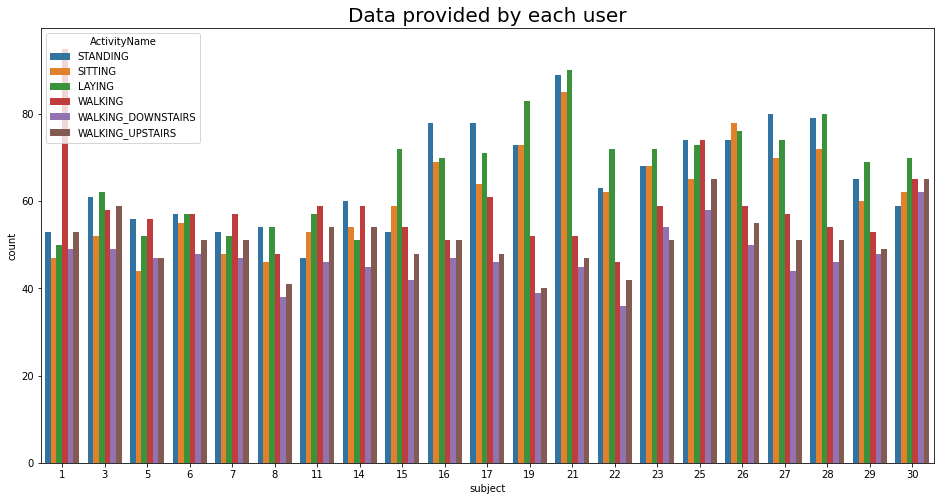

In [15]:
plt.figure(figsize=(16,8))
plt.title('Data provided by each user', fontsize=20)
sns.countplot(x='subject',hue='ActivityName', data = train)
plt.show()

<h3> Observation:  </h3>
<pre>
We have got almost same number of reading from all the subjects
</pre>

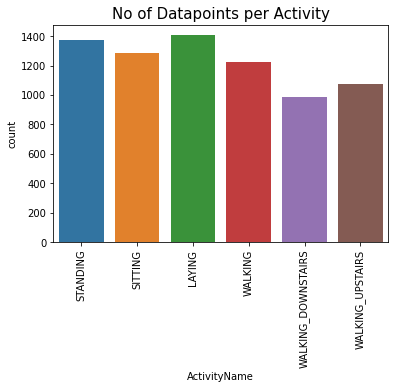

In [16]:
plt.title('No of Datapoints per Activity', fontsize=15)
sns.countplot(train.ActivityName)
plt.xticks(rotation=90)
plt.show()

<h3> Observation: </h3>
<pre>The count for each target variable is almost same hence can be considered as balanced</pre>

<h3> Changing the feature Names </h3>

In [17]:
columns = train.columns

# Removing '()' from column names
# Removing '-' from column names
# Removing ',' from column names

#we haven't removed _ that we had added do as to identify the column names that were changed 
columns = columns.str.replace('[()]','')
columns = columns.str.replace('[-]', '')
columns = columns.str.replace('[,]','')

train.columns = columns
test.columns = columns

test.columns

Index(['tBodyAccmeanX', 'tBodyAccmeanY', 'tBodyAccmeanZ', 'tBodyAccstdX',
       'tBodyAccstdY', 'tBodyAccstdZ', 'tBodyAccmadX', 'tBodyAccmadY',
       'tBodyAccmadZ', 'tBodyAccmaxX',
       ...
       'angletBodyAccMeangravity', 'angletBodyAccJerkMeangravityMean',
       'angletBodyGyroMeangravityMean', 'angletBodyGyroJerkMeangravityMean',
       'angleXgravityMean', 'angleYgravityMean', 'angleZgravityMean',
       'subject', 'Activity', 'ActivityName'],
      dtype='object', length=564)

<h3> Saving updated DataFrame in a CSV files </h3>

In [18]:
train.to_csv('/content/drive/MyDrive/project/Human activity recognition /UCI_HAR_Dataset/csv_files/train.csv', index=False)
test.to_csv('/content/drive/MyDrive/project/Human activity recognition /UCI_HAR_Dataset/csv_files/test.csv', index=False)


<h3> EDA on Engineered Features </h3>

In [19]:
sns.set_style('whitegrid')
plt.rcParams['font.family'] = 'Dejavu Sans'

<h3> We can differentiate between stationary and moving activities </h3>

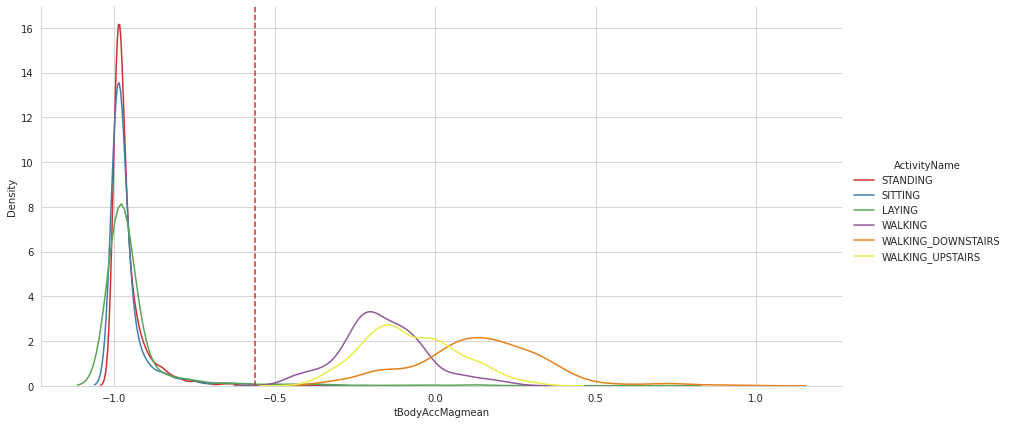

In [21]:
sns.set_palette("Set1", desat=0.80)
facetgrid = sns.FacetGrid(train, hue='ActivityName', size=6,aspect=2)
facetgrid.map(sns.distplot,'tBodyAccMagmean', hist=False)\
    .add_legend()
plt.axvline(-0.56,ls="--")
plt.show()

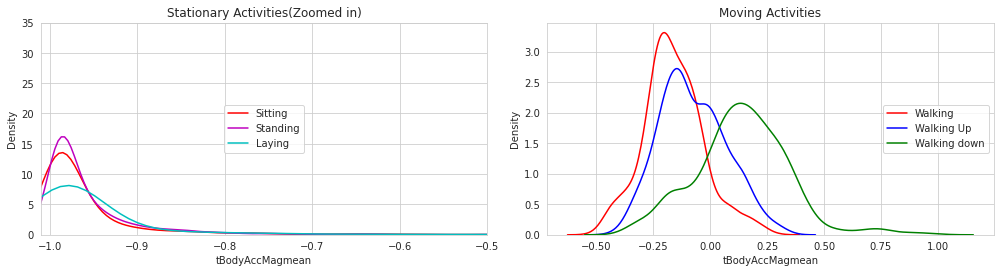

In [22]:
df1 = train[train['Activity']==1]
df2 = train[train['Activity']==2]
df3 = train[train['Activity']==3]
df4 = train[train['Activity']==4]
df5 = train[train['Activity']==5]
df6 = train[train['Activity']==6]

plt.figure(figsize=(14,7))
plt.subplot(2,2,1)
plt.title('Stationary Activities(Zoomed in)')
sns.distplot(df4['tBodyAccMagmean'],color = 'r',hist = False, label = 'Sitting')
sns.distplot(df5['tBodyAccMagmean'],color = 'm',hist = False,label = 'Standing')
sns.distplot(df6['tBodyAccMagmean'],color = 'c',hist = False, label = 'Laying')
plt.axis([-1.01, -0.5, 0, 35])
plt.legend(loc='center')

plt.subplot(2,2,2)
plt.title('Moving Activities')
sns.distplot(df1['tBodyAccMagmean'],color = 'red',hist = False, label = 'Walking')
sns.distplot(df2['tBodyAccMagmean'],color = 'blue',hist = False,label = 'Walking Up')
sns.distplot(df3['tBodyAccMagmean'],color = 'green',hist = False, label = 'Walking down')
plt.legend(loc='center right')


plt.tight_layout()
plt.show()

<h3> Mag of Acceleration easliy saperates these  activities </h3> 

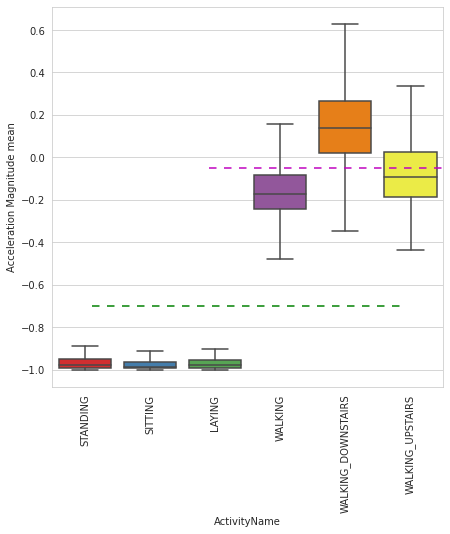

In [23]:
plt.figure(figsize=(7,7))
sns.boxplot(x='ActivityName', y='tBodyAccMagmean',data=train, showfliers=False, saturation=1)
plt.ylabel('Acceleration Magnitude mean')
plt.axhline(y=-0.7, xmin=0.1, xmax=0.9,dashes=(5,5), c='g')
plt.axhline(y=-0.05, xmin=0.4, dashes=(5,5), c='m')
plt.xticks(rotation=90)
plt.show()

<pre> 
Observations

1. If tAccMean is < -0.8 then the Activities are either Standing or Sitting or Laying.
2. If tAccMean is > -0.6 then the Activities are either Walking or WalkingDownstairs or WalkingUpstairs.
3. If tAccMean > 0.0 then the Activity is WalkingDownstairs.
4. We can classify 75% the Acitivity labels with some errors.

</pre>

<h3> Position of Gravity Acceleration components also matters </h3> 

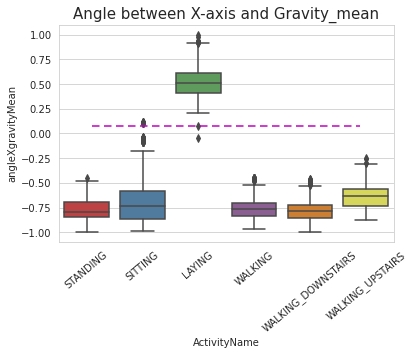

In [ ]:
sns.boxplot(x='ActivityName', y='angleXgravityMean', data=train)
plt.axhline(y=0.08, xmin=0.1, xmax=0.9,c='m',dashes=(5,3))
plt.title('Angle between X-axis and Gravity_mean', fontsize=15)
plt.xticks(rotation = 40)
plt.show()

<pre>
Observations

1. If angleX,gravityMean > 0 then Activity is Laying.
2. We can classify all datapoints belonging to Laying activity with just a single if else statement.
</pre>

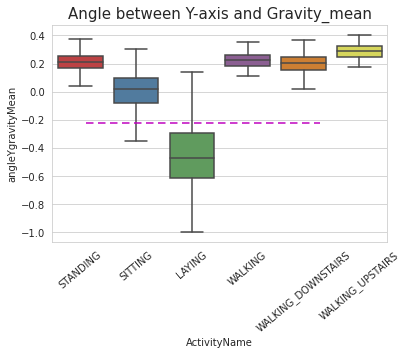

In [ ]:
sns.boxplot(x='ActivityName', y='angleYgravityMean', data = train, showfliers=False)
plt.title('Angle between Y-axis and Gravity_mean', fontsize=15)
plt.xticks(rotation = 40)
plt.axhline(y=-0.22, xmin=0.1, xmax=0.8, dashes=(5,3), c='m')
plt.show()

<h3> T-SNE on the Engineered Features </h3>

In [25]:
# performs t-sne with different perplexity values and their repective plots..

def perform_tsne(X_data, y_data, perplexities, n_iter=1000, img_name_prefix='t-sne'):
        
    for index,perplexity in enumerate(perplexities):
        # perform t-sne
        print('\nperforming tsne with perplexity {} and with {} iterations at max'.format(perplexity, n_iter))
        X_reduced = TSNE(verbose=2, perplexity=perplexity).fit_transform(X_data)
        print('Done..')
        
        # prepare the data for seaborn         
        print('Creating plot for this t-sne visualization..')
        df = pd.DataFrame({'x':X_reduced[:,0], 'y':X_reduced[:,1] ,'label':y_data})
        
        # draw the plot in appropriate place in the grid
        sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,\
                   palette="Set1",markers=['^','v','s','o', '1','2'])
        plt.title("perplexity : {} and max_iter : {}".format(perplexity, n_iter))
        img_name = img_name_prefix + '_perp_{}_iter_{}.png'.format(perplexity, n_iter)
        print('saving this plot as image in present working directory...')
        plt.savefig(img_name)
        plt.show()
        print('Done')



performing tsne with perplexity 2 and with 1000 iterations at max
[t-SNE] Computing 7 nearest neighbors...
[t-SNE] Indexed 7352 samples in 0.009s...
[t-SNE] Computed neighbors for 7352 samples in 2.038s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7352
[t-SNE] Computed conditional probabilities for sample 2000 / 7352
[t-SNE] Computed conditional probabilities for sample 3000 / 7352
[t-SNE] Computed conditional probabilities for sample 4000 / 7352
[t-SNE] Computed conditional probabilities for sample 5000 / 7352
[t-SNE] Computed conditional probabilities for sample 6000 / 7352
[t-SNE] Computed conditional probabilities for sample 7000 / 7352
[t-SNE] Computed conditional probabilities for sample 7352 / 7352
[t-SNE] Mean sigma: 0.597443
[t-SNE] Computed conditional probabilities in 0.047s
[t-SNE] Iteration 50: error = 124.7495728, gradient norm = 0.0288854 (50 iterations in 4.187s)
[t-SNE] Iteration 100: error = 106.9046402, gradient norm = 0.0288064 (50 iterations in 

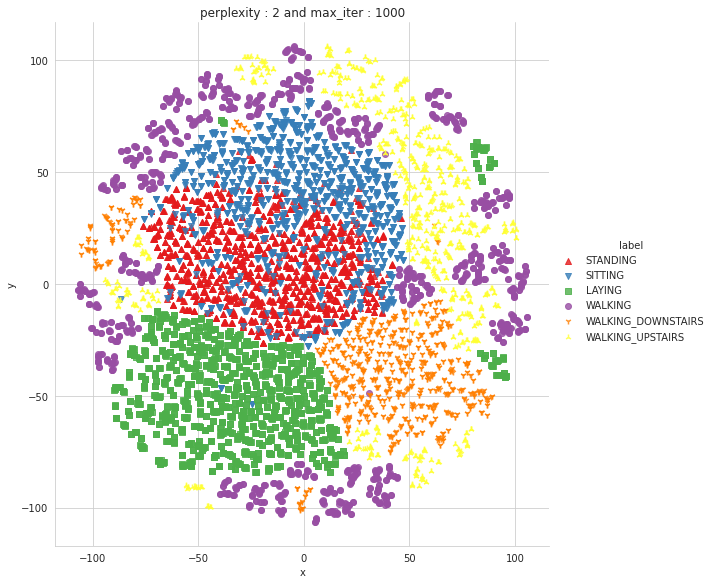

Done

performing tsne with perplexity 5 and with 1000 iterations at max
[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 7352 samples in 0.005s...
[t-SNE] Computed neighbors for 7352 samples in 1.835s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7352
[t-SNE] Computed conditional probabilities for sample 2000 / 7352
[t-SNE] Computed conditional probabilities for sample 3000 / 7352
[t-SNE] Computed conditional probabilities for sample 4000 / 7352
[t-SNE] Computed conditional probabilities for sample 5000 / 7352
[t-SNE] Computed conditional probabilities for sample 6000 / 7352
[t-SNE] Computed conditional probabilities for sample 7000 / 7352
[t-SNE] Computed conditional probabilities for sample 7352 / 7352
[t-SNE] Mean sigma: 0.961446
[t-SNE] Computed conditional probabilities in 0.071s
[t-SNE] Iteration 50: error = 113.7799835, gradient norm = 0.0252237 (50 iterations in 3.865s)
[t-SNE] Iteration 100: error = 97.7275162, gradient norm = 0.0154823 (50 iteration

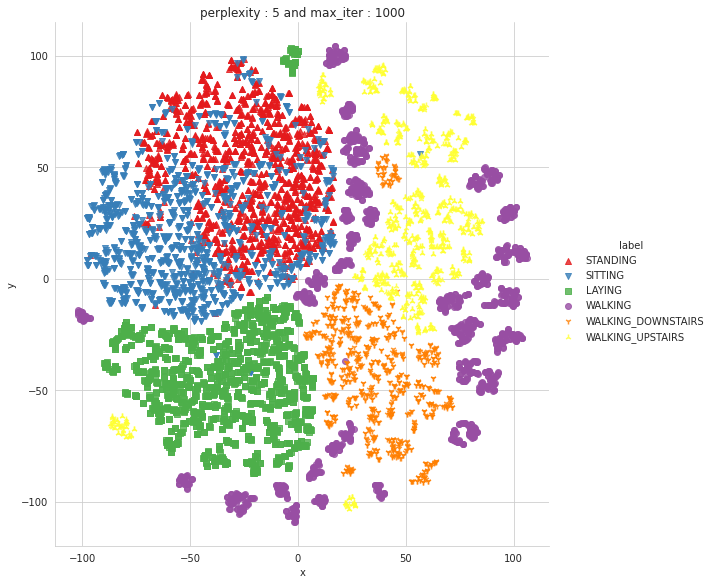

Done

performing tsne with perplexity 10 and with 1000 iterations at max
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 7352 samples in 0.004s...
[t-SNE] Computed neighbors for 7352 samples in 1.807s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7352
[t-SNE] Computed conditional probabilities for sample 2000 / 7352
[t-SNE] Computed conditional probabilities for sample 3000 / 7352
[t-SNE] Computed conditional probabilities for sample 4000 / 7352
[t-SNE] Computed conditional probabilities for sample 5000 / 7352
[t-SNE] Computed conditional probabilities for sample 6000 / 7352
[t-SNE] Computed conditional probabilities for sample 7000 / 7352
[t-SNE] Computed conditional probabilities for sample 7352 / 7352
[t-SNE] Mean sigma: 1.133827
[t-SNE] Computed conditional probabilities in 0.119s
[t-SNE] Iteration 50: error = 105.2664185, gradient norm = 0.0241697 (50 iterations in 4.548s)
[t-SNE] Iteration 100: error = 90.2224426, gradient norm = 0.0110341 (50 iteratio

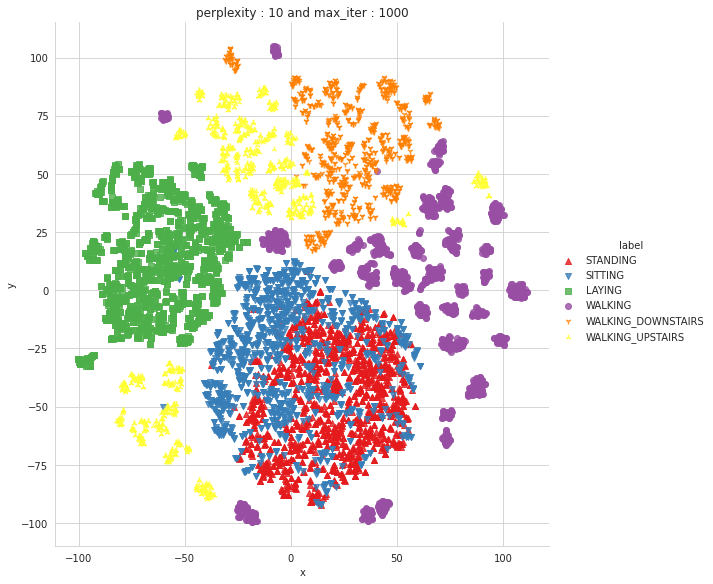

Done

performing tsne with perplexity 20 and with 1000 iterations at max
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 7352 samples in 0.004s...
[t-SNE] Computed neighbors for 7352 samples in 1.944s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7352
[t-SNE] Computed conditional probabilities for sample 2000 / 7352
[t-SNE] Computed conditional probabilities for sample 3000 / 7352
[t-SNE] Computed conditional probabilities for sample 4000 / 7352
[t-SNE] Computed conditional probabilities for sample 5000 / 7352
[t-SNE] Computed conditional probabilities for sample 6000 / 7352
[t-SNE] Computed conditional probabilities for sample 7000 / 7352
[t-SNE] Computed conditional probabilities for sample 7352 / 7352
[t-SNE] Mean sigma: 1.274336
[t-SNE] Computed conditional probabilities in 0.230s
[t-SNE] Iteration 50: error = 97.4142685, gradient norm = 0.0196475 (50 iterations in 4.245s)
[t-SNE] Iteration 100: error = 83.9018250, gradient norm = 0.0067926 (50 iteration

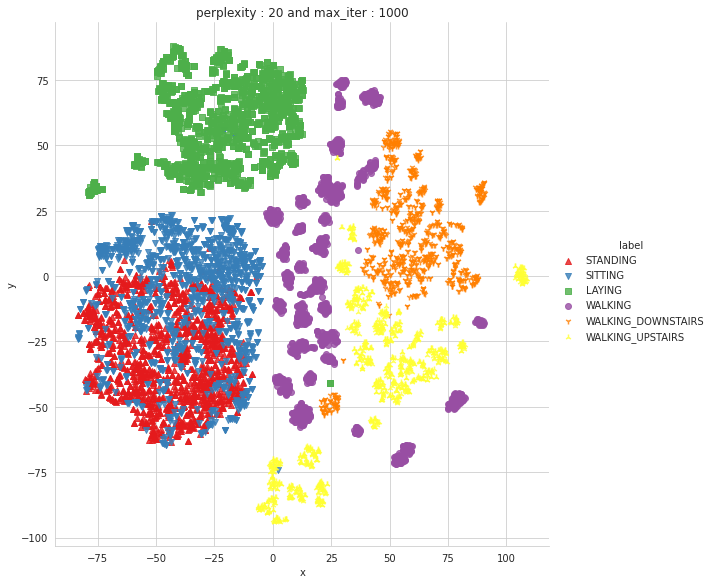

Done

performing tsne with perplexity 50 and with 1000 iterations at max
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 7352 samples in 0.005s...
[t-SNE] Computed neighbors for 7352 samples in 1.980s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7352
[t-SNE] Computed conditional probabilities for sample 2000 / 7352
[t-SNE] Computed conditional probabilities for sample 3000 / 7352
[t-SNE] Computed conditional probabilities for sample 4000 / 7352
[t-SNE] Computed conditional probabilities for sample 5000 / 7352
[t-SNE] Computed conditional probabilities for sample 6000 / 7352
[t-SNE] Computed conditional probabilities for sample 7000 / 7352
[t-SNE] Computed conditional probabilities for sample 7352 / 7352
[t-SNE] Mean sigma: 1.437672
[t-SNE] Computed conditional probabilities in 0.557s
[t-SNE] Iteration 50: error = 86.0639191, gradient norm = 0.0245509 (50 iterations in 5.072s)
[t-SNE] Iteration 100: error = 75.8570557, gradient norm = 0.0059355 (50 iteratio

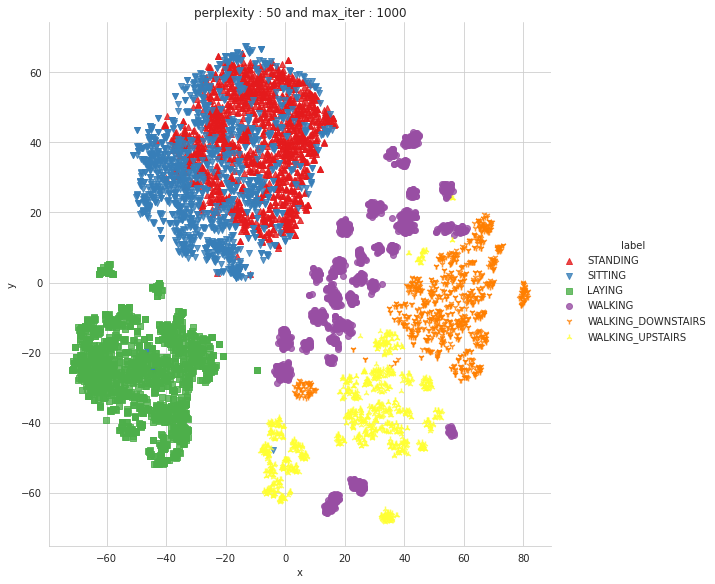

Done


In [26]:
X_pre_tsne = train.drop(['subject', 'Activity','ActivityName'], axis=1)
y_pre_tsne = train['ActivityName']
perform_tsne(X_data = X_pre_tsne,y_data=y_pre_tsne, perplexities =[2,5,10,20,50])